This notebook will load the test image and trained model:

In [9]:
import gc

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image

# load metadata.csv

In [10]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

# preprocess labels

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
5208  HAM_0006752  ISIC_0031842   nv  follow_up  45.0    male   
5768  HAM_0000635  ISIC_0028663   nv  follow_up  60.0  female   
9114  HAM_0001701  ISIC_0029390   nv      histo  65.0    male   
950   HAM_0000571  ISIC_0033156  bkl  consensus  70.0    male   
4602  HAM_0001874  ISIC_0024601   nv  follow_up  40.0  female   

         localization  label  
5208             back      5  
5768  lower extremity      5  
9114  lower extremity      5  
950              back      2  
4602            trunk      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [133]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

# Preprocess image

In [13]:
from glob import glob
image_size = 150 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [17]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))


# Image to array

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list()).astype("short")
label_to_one_hot = to_categorical(df['label'], num_classes=7)


# Split train, test data

In [48]:
#80% data for training
#20% data for testing
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)
test_data = test_data/255.0

load trained model



In [156]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16,InceptionV3
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Model
model_VGG_16 = load_model("model/VGG_16.h5")
model_EF_Net = load_model("model/Efficient_Net_model.h5")
model_INC = load_model("model/InceptionV3.h5")

In [42]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Confusion Matrix and score

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
def print_confusion_matrix(model):
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    score = model.evaluate(test_data, test_label)
    print('Test accuracy:', score[1])

    prediction = model.predict(test_data)
    prediction_class = np.argmax(prediction,axis=1)
    prediction_label = np.argmax(test_label,axis=1)

    mapping = lambda x:features_dict[x]
    pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
    pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
    matrix = confusion_matrix(pred_label_to_feature,pred_class_to_feature)
    matrix_display = ConfusionMatrixDisplay(matrix)
    fig,x = plt.subplots(figsize =(12,12))
    matrix_display.plot(ax=x)
    print(classification_report(pred_label_to_feature,pred_class_to_feature,target_names=labels))
    #print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,colnames=['predicted']))

63/63 [==============================] - 6s 99ms/step - loss: 1.0687 - acc: 0.7743

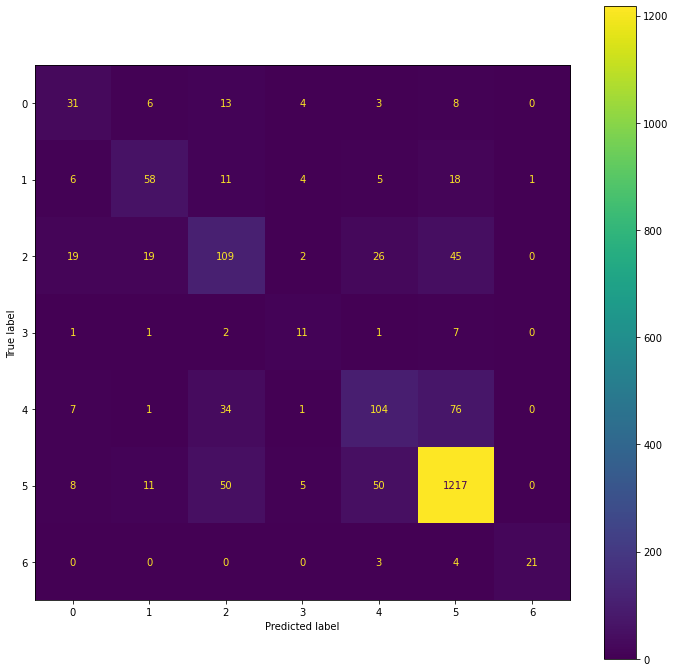

In [153]:
print_confusion_matrix(model_VGG_16)

63/63 [==============================] - 7s 58ms/step - loss: 0.8428 - acc: 0.7763

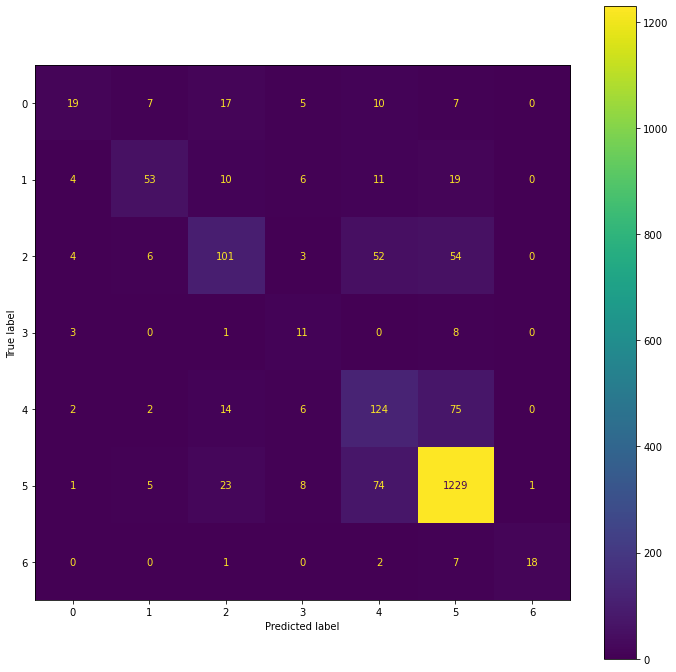

In [154]:
print_confusion_matrix(model_INC)

63/63 [==============================] - 6s 57ms/step - loss: 0.7388 - acc: 0.7813

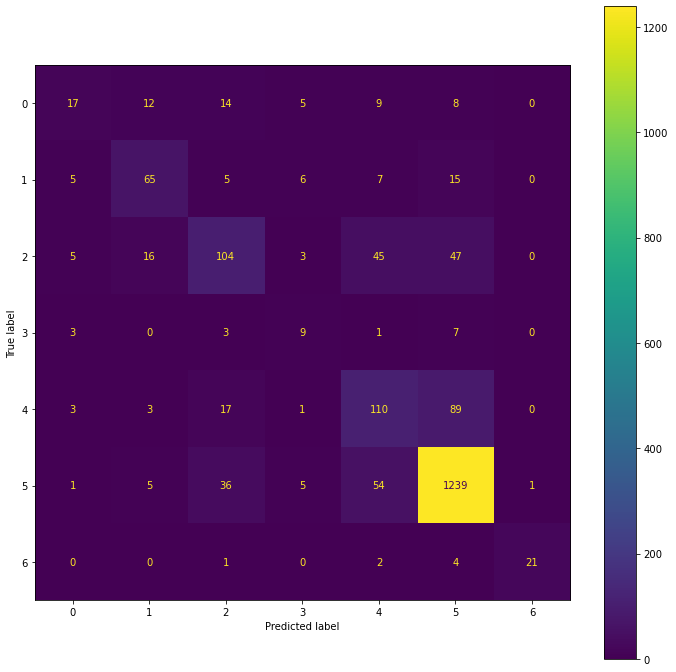

In [155]:
print_confusion_matrix(model_EF_Net)

load demo image using keras library
reference https://stackoverflow.com/questions/50227925/how-to-predict-from-saved-model-in-keras

In [84]:
from tensorflow.keras.preprocessing import image
path_aki = 'demo\\ak'
path_bcc = 'demo\\bcc'
path_bkl = 'demo\\bkl'
path_df = 'demo\\df'
path_mel = 'demo\\mel'
path_nv_1 = 'demo\\nv_1'
path_vasc = 'demo\\vasc'

image_path_aki = [x for x in glob(os.path.join(path_aki,'*.jpg'))]
image_path_bcc = [x for x in glob(os.path.join(path_bcc,'*.jpg'))]
image_path_bkl = [x for x in glob(os.path.join(path_bkl,'*.jpg'))]
image_path_df = [x for x in glob(os.path.join(path_df,'*.jpg'))]
image_path_mel = [x for x in glob(os.path.join(path_mel,'*.jpg'))]
image_path_nv_1 = [x for x in glob(os.path.join(path_nv_1,'*.jpg'))]
image_path_vasc = [x for x in glob(os.path.join(path_vasc,'*.jpg'))]

# predict with real image:

In [157]:
image_class = image_path_vasc
from tensorflow.keras.preprocessing import image
for images in image_class:
    test_image = image.load_img(images,target_size=(150,150))
    test_image = image.img_to_array(test_image)
    test_image = test_image/255.0
    test_image = np.expand_dims(test_image,axis = 0)
    result_VGG = model_VGG_16.predict(test_image)
    prediction_VGG = np.argmax(result_VGG,axis=1)
    print("VGG-16: predicted ",features_dict[prediction_VGG[0]])

    result_INC = model_INC.predict(test_image)
    prediction_INC = np.argmax(result_INC,axis=1)
    print("Inception V3: predicted ",features_dict[prediction_INC[0]])

    result_EFN = model_EF_Net.predict(test_image)
    prediction_EFN = np.argmax(result_EFN,axis=1)
    print("Efficient Net: predicted ",features_dict[prediction_EFN[0]])

    print()

FileNotFoundError: [Errno 2] No such file or directory: 'demo\\vasc\\vasc_1.jpg'